# Analyzing Apple AppStore Data (with SQL and Python)

## Dataset

The dataset contains data about a selection of apps in the Apple AppStore from July 2017. It is available on [Kaggle](https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps) and includes two CSV files:
- AppleStore.csv
- AppleStore_description.csv

## Goal
A software company or an independent developer would like to develop an app for the Apple AppStore. For this purpose, it should be analyzed what appears to be the most promising for an app. The following questions should therefore be answered as part of the analysis:
- Which genre should the app belong to?
- Should the app be free or paid? If paid, at what price?
- How many languages should the app support?
- Should the app have a rather short or long description?

## Database Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read CSVs to pandas dataframes
df_apps = pd.read_csv("AppleStore.csv")
df_apps = df_apps.iloc[:, 1:]
df_apps.head()

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [3]:
df_apps_desc = pd.read_csv("AppleStore_description.csv")
df_apps_desc.head()

,id,track_name,size_bytes,app_desc
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,On more than 250 million devices around the wo...


In [4]:
# Establish connector for SQLite database
con = sqlite3.connect("apps.db")

In [5]:
# Convert dataframe to table "appstore" in database
df_apps.to_sql("apps", con, index=False)
df_apps_desc.to_sql("desc", con, index=False)

7197

In [6]:
# Load SQL module
%load_ext sql

In [7]:
# Connect to database
%sql sqlite:///apps.db

## Table Overview

In [8]:
%%sql
-- Quick overview of apps table
SELECT *
FROM apps
LIMIT 5;

 * sqlite:///apps.db
Done.


id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
281796108,Evernote - stay organized,158578688,USD,0.0,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.0,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
282614216,"eBay: Best App to Buy, Sell, Save! Online Shopping",128512000,USD,0.0,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
282935706,Bible,92774400,USD,0.0,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [9]:
%%sql
-- Quick overview of desc table
SELECT *
FROM desc
LIMIT 1;

 * sqlite:///apps.db
Done.


id,track_name,size_bytes,app_desc
281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!One of the most popular video games in arcade history!2015 World Video Game Hall of Fame InducteeWho can forget the countless hours and quarters spent outrunning pesky ghosts and chompin’ on dots? Now you can have the same arcade excitement on your mobile devices! Guide PAC-MAN through the mazes with easy swipe controls, a MFi controller, or kick it old school with the onscreen joystick!Eat all of the dots to advance to the next stage. Go for high scores and higher levels! Gain an extra life at 10.000 points! Gobble Power Pellets to weaken ghosts temporarily and eat them up before they change back. Avoid Blinky, the leader of the ghosts, and his fellow ghosts Pinky, Inky, and Clyde, or you will lose a life. It’s game over when you lose all your lives.9 NEW MAZES Included!!!The game includes 9 new mazes in addition to the pixel for pixel recreation of the classic original maze. Challenge your skill to beat them all! We are constantly updating the game with new maze packs that you can buy to complete your PAC-MAN collection.HINTS and TIPS!!!Insider pro-tips and hints are being made available for the first time in-game! Use these to help you become a PAC-MAN champion!FEATURES:• New tournaments• New Visual Hints and Pro-tips• New mazes for all new challenges• Play an arcade perfect port of classic PAC-MAN• Two different control modes• Three game difficulties (including the original 1980 arcade game)• Retina display support• MFi controller support"


The dataset's author states that the iTunes API was used to collect the data. This might explain why the app names are referred to as "track_name". Since the data is all about apps and not tracks, the column "track_name" will be renamed to "app_name" in both tables.

In [10]:
%%sql
-- Renaming "track_name" to "app_name" in table "apps"
ALTER TABLE apps
RENAME COLUMN track_name TO app_name

 * sqlite:///apps.db
Done.


[]

In [11]:
%%sql
-- Renaming "track_name" to "app_name" in table "desc"
ALTER TABLE desc
RENAME COLUMN track_name TO app_name

 * sqlite:///apps.db
Done.


[]

## Data Completeness

### Unique and Matching IDs

In [12]:
%%sql
-- Check unique rows for table "apps"
SELECT COUNT(DISTINCT id) AS unique_ids_apps
FROM apps

 * sqlite:///apps.db
Done.


unique_ids_apps
7197


In [13]:
%%sql
-- Check unique rows for table "desc"
SELECT COUNT(DISTINCT id) AS unique_ids_desc
FROM desc

 * sqlite:///apps.db
Done.


unique_ids_desc
7197


In [14]:
%%sql
-- Check IDs that don't appear in both tables
SELECT COUNT(*) AS count_missing_ids
FROM (
    -- IDs from "apps" not in "desc"
    SELECT apps.id
    FROM apps
    LEFT JOIN desc ON apps.id = desc.id
    WHERE desc.id IS NULL

    UNION ALL
    
    -- IDs from "desc" not in "apps"
    SELECT desc.id
    FROM desc
    LEFT JOIN apps ON desc.id = apps.id
    WHERE apps.id IS NULL
)

 * sqlite:///apps.db
Done.


count_missing_ids
0


### Missing Values

In [15]:
%%sql
-- Check for missing values in relevant columns in "apps"
SELECT COUNT(*) AS missing_values
FROM apps
WHERE
    app_name IS NULL OR
    rating_count_tot IS NULL OR
    price IS NULL OR
    user_rating IS NULL OR
    prime_genre IS NULL

 * sqlite:///apps.db
Done.


missing_values
0


In [16]:
%%sql
-- Check for missing values in relevant columns in "desc"
SELECT COUNT(*) AS missing_values
FROM desc
WHERE
    app_name IS NULL OR
    app_desc IS NULL

 * sqlite:///apps.db
Done.


missing_values
0


All IDs from the "apps" table are contained in "desc" and vice versa. The dataset is ready for analysis.

## AppStore Analysis

### App Genres

In [17]:
%%sql
-- Group several measures of apps by genre
SELECT
    prime_genre,
    COUNT(*) AS count_apps,
    ROUND(AVG(user_rating), 2) AS avg_rating,
    ROUND(AVG(rating_count_tot), 2) AS avg_rating_count,
    ROUND(AVG(price), 2) AS avg_price
FROM apps
GROUP BY prime_genre
ORDER BY count_apps DESC

 * sqlite:///apps.db
Done.


prime_genre,count_apps,avg_rating,avg_rating_count,avg_price
Games,3862,3.69,13692.0,1.43
Entertainment,535,3.25,7533.68,0.89
Education,453,3.38,2239.23,4.03
Photo & Video,349,3.8,14352.28,1.47
Utilities,248,3.28,6863.82,1.65
Health & Fitness,180,3.7,9913.17,1.92
Productivity,178,4.01,8051.33,4.33
Social Networking,167,2.99,45498.9,0.34
Lifestyle,144,2.81,6161.76,0.89
Music,138,3.98,28842.02,4.84


There are 23 different genres. More than half belong to the "Games" genre.

In [18]:
%%sql
-- Group several measures of apps by genre
SELECT
    prime_genre,
    COUNT(*) AS count_apps,
    ROUND(AVG(user_rating), 2) AS avg_rating,
    ROUND(AVG(rating_count_tot), 2) AS avg_rating_count,
    ROUND(AVG(price), 2) AS avg_price
FROM apps
GROUP BY prime_genre
ORDER BY avg_rating ASC

 * sqlite:///apps.db
Done.


prime_genre,count_apps,avg_rating,avg_rating_count,avg_price
Catalogs,10,2.1,1732.5,0.8
Finance,104,2.43,11047.65,0.42
Book,112,2.48,5125.44,1.79
Navigation,46,2.68,11853.96,4.12
Lifestyle,144,2.81,6161.76,0.89
News,75,2.98,13015.07,0.52
Sports,114,2.98,14026.93,0.95
Social Networking,167,2.99,45498.9,0.34
Food & Drink,63,3.18,13938.62,1.55
Entertainment,535,3.25,7533.68,0.89


Sorting by the average rating shows that the "Catalogs" genre has the lowest average rating and also only a small selection with 10 different apps. So it might be worth developing a good app for this genre. Other promising genres are "Finance", "Book" and "Navigation".

In [20]:
%%sql
-- List top 3 apps per promising genre that have more than 10 reviews
SELECT
    prime_genre,
    app_name,
    user_rating,
    rating_count_tot
FROM (
      -- Create a subquery with genre, app name, ratings count, rating and rank
      SELECT
      prime_genre,
      app_name,
      rating_count_tot,
      user_rating,
      -- Calculate ranks for apps per genre
      RANK() OVER(
                  PARTITION BY prime_genre
                  ORDER BY
                      user_rating DESC,
                      rating_count_tot DESC
                      ) AS rank
      FROM apps
      WHERE
          -- Only consider apps with more than 10 reviews
          rating_count_tot > 10 AND
          prime_genre IN (
                          -- List 4 most promising genres
                          SELECT prime_genre
                          FROM apps
                          GROUP BY prime_genre
                          ORDER BY AVG(user_rating) ASC
                          LIMIT 4
                         )
     ) AS subquery
-- List top 3 per genre
WHERE subquery.rank <= 3

 * sqlite:///apps.db
Done.


prime_genre,app_name,user_rating,rating_count_tot
Book,Color Therapy Adult Coloring Book for Adults,5.0,84062
Book,喜马拉雅FM（听书社区）电台有声小说相声英语,5.0,2111
Book,快看漫画,5.0,1647
Catalogs,CPlus for Craigslist app - mobile classifieds,5.0,13345
Catalogs,My Movies Pro - Movie & TV Collection Library,4.5,1309
Catalogs,DRAGONS MODS FREE for Minecraft PC Game Edition,4.0,2027
Finance,"Credit Karma: Free Credit Scores, Reports & Alerts",5.0,101679
Finance,家計簿マネーフォワード-自動連携で簡単 人気の家計簿,5.0,14
Finance,楽天カード,5.0,11
Navigation,"Waze - GPS Navigation, Maps & Real-time Traffic",4.5,345046


The above apps could serve as inspiration because they are highly rated in an  overall poorly rated genre. Some appear to be Asian and might be difficult to understand. If that is a problem, these apps should be filtered out.

### Free vs. Paid Apps

In [21]:
%%sql
-- Compare free and paid apps
SELECT
    CASE
        WHEN price = 0 THEN "Free"
        ELSE "Paid"
    END AS Cost,
    COUNT(price) AS count_apps,
    ROUND(AVG(rating_count_tot), 2) AS avg_rating_count,
    ROUND(AVG(user_rating), 2) AS avg_rating,
    ROUND(AVG(price), 2) AS avg_price
FROM apps
GROUP BY Cost
ORDER BY count_apps DESC

 * sqlite:///apps.db
Done.


Cost,count_apps,avg_rating_count,avg_rating,avg_price
Free,4056,19749.8,3.38,0.0
Paid,3141,4038.54,3.72,3.96


In [22]:
# Create dataframe for user_rating, price and count_apps
query = """
    SELECT
        user_rating,
        price,
        COUNT(*) AS count_apps
    FROM apps
    WHERE NOT price = 0
    GROUP BY user_rating, price
"""

df_price_rating = pd.read_sql(query, con)
avg_price = (df_price_rating['price'] * df_price_rating['count_apps']).sum() / df_price_rating['count_apps'].sum()
print(avg_price)
df_price_rating.head()

3.955297675899395


,user_rating,price,count_apps
0,0.0,0.99,97
1,0.0,1.99,34
2,0.0,2.99,33
3,0.0,3.99,21
4,0.0,4.99,25


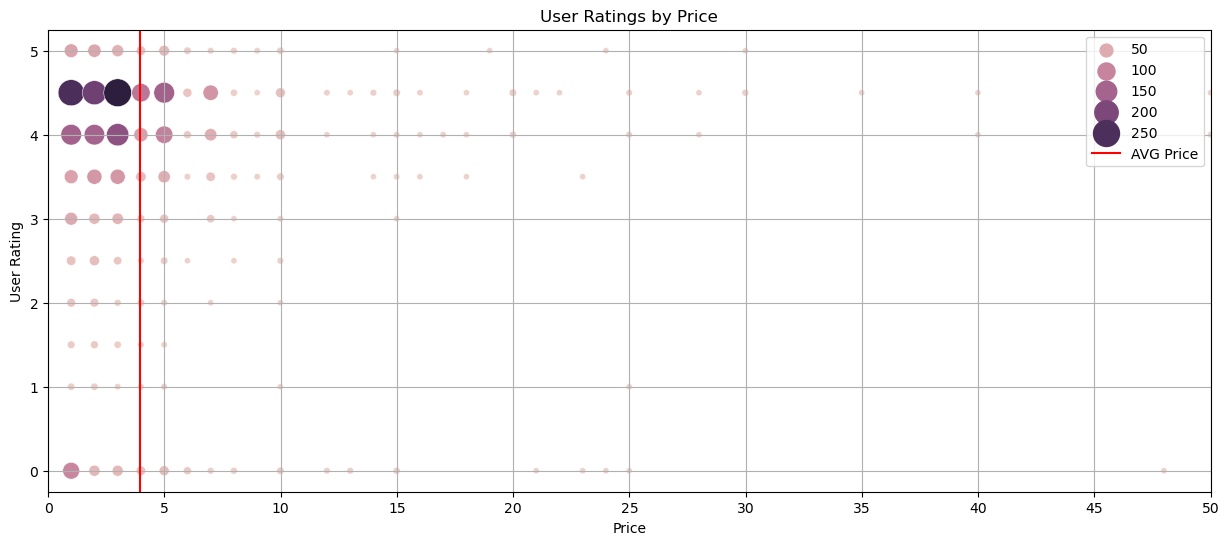

In [23]:
# Plot user ratings and prices
plt.figure(figsize=(15, 6))
sns.scatterplot(x="price", y="user_rating", hue="count_apps", size="count_apps", sizes=(20, 400), data=df_price_rating)
plt.axvline(x = avg_price, color = 'r', label = 'AVG Price')
plt.xlim(0, 50)
plt.xticks(np.arange(0, 51, 5))
plt.grid(True)
plt.legend()
plt.title("User Ratings by Price")
plt.xlabel("Price")
plt.ylabel("User Rating")
plt.show()

There are more free apps available which receive significantly more reviews on average, but the average rating is higher for paid apps. The price for an app might depend heavily on competing apps and the genre. In general, however, a price of less than 4 dollars should be aimed at in order not to be above average and thus deter potential customers. Apps priced below average are rated 4 or higher most often.

### Number of Supported Languages

In [24]:
%%sql
-- Find out how many apps support a certain number of languages
SELECT
    CASE
        WHEN "lang.num" = 0 THEN "0"
        WHEN "lang.num" = 1 THEN "1"
        WHEN "lang.num" BETWEEN 2 AND 10 THEN "2-10"
        WHEN "lang.num" BETWEEN 11 AND 20 THEN "11-20"
        WHEN "lang.num" BETWEEN 21 AND 50 THEN "21-50"
        WHEN "lang.num" > 51 THEN ">50"
    END AS language_bin,
    COUNT(*) AS count_apps,
    ROUND(AVG(user_rating), 2) AS avg_rating
FROM apps
GROUP BY language_bin
ORDER BY "lang.num"

 * sqlite:///apps.db
Done.


language_bin,count_apps,avg_rating
0,41,1.89
1,3767,3.38
2-10,1980,3.46
11-20,1032,4.14
21-50,352,3.9
>50,25,4.04


41 apps have a value of zero for supported languages. This seems to be a lack of data quality, so the affected apps should be further investigated to evaluate the impact on the overall analysis. The avg_rating indicates that the affected apps are mostly not very popular.

In [25]:
%%sql
-- List counts and averages for relevant columns per genre for each app with 0 supported languages
SELECT
    prime_genre,
    COUNT(*) AS count_apps,
    AVG(price) AS avg_price,
    AVG(rating_count_tot) AS avg_rating_count,
    AVG(user_rating) AS avg_rating
FROM apps
WHERE "lang.num" = 0
GROUP BY prime_genre
ORDER BY count_apps DESC

 * sqlite:///apps.db
Done.


prime_genre,count_apps,avg_price,avg_rating_count,avg_rating
Games,30,0.6643333333333333,1877.1,2.05
Finance,2,0.0,0.0,0.0
Education,2,2.49,32.0,1.75
Weather,1,0.99,10.0,4.5
Social Networking,1,0.0,0.0,0.0
Photo & Video,1,0.0,0.0,0.0
News,1,0.0,0.0,0.0
Music,1,0.0,355.0,3.0
Entertainment,1,5.99,2.0,5.0
Business,1,1.99,0.0,0.0


The clear majority of affected apps have the highest average rating and belong to the "Games" genre. For the further course of the analysis, it is therefore assumed that the results with regard to the "games" genre are not greatly distorted due to the already high number of games in the data set.

In [26]:
# Create dataframe for avg_ratings per language_bin
query = """
    SELECT
        CASE
            WHEN "lang.num" = 0 THEN "0"
            WHEN "lang.num" = 1 THEN "1"
            WHEN "lang.num" BETWEEN 2 AND 10 THEN "2-10"
            WHEN "lang.num" BETWEEN 11 AND 20 THEN "11-20"
            WHEN "lang.num" BETWEEN 21 AND 50 THEN "21-50"
            WHEN "lang.num" > 51 THEN ">50"
        END AS language_bin,
        ROUND(AVG(user_rating), 2) AS avg_rating
    FROM apps
    GROUP BY language_bin
    ORDER BY "lang.num"
"""

df_lang_rating = pd.read_sql(query, con)
df_lang_rating.head()

,language_bin,avg_rating
0,0,1.89
1,1,3.38
2,2-10,3.46
3,11-20,4.14
4,21-50,3.90


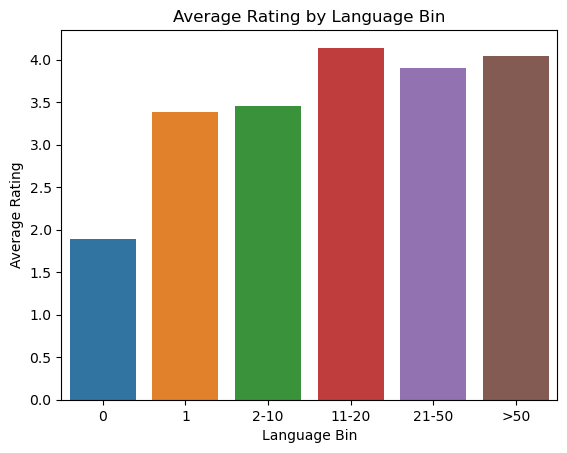

In [27]:
# Plot average ratings by language bin
sns.barplot(x="language_bin", y="avg_rating", data=df_lang_rating)
plt.xlabel("Language Bin")
plt.ylabel("Average Rating")
plt.title("Average Rating by Language Bin")
plt.show()

In order to achieve higher ratings, it is not necessary to support more than 20 languages, but supporting <b>more than 10 languages</b> yields the best results in terms of ratings.

### Importance of Description Length

In [33]:
%%sql
-- Get minimum, maximum and average of description length in characters
SELECT
    MIN(LENGTH(app_desc)) AS Min,
    MAX(LENGTH(app_desc)) AS Max,
    AVG(LENGTH(app_desc)) AS Avg
FROM desc

 * sqlite:///apps.db
Done.


Min,Max,Avg
17,4000,1553.7141864665832


With a maximum value of 4000 characters for app descriptions, all apps can be assigned to one of eight equally sized bins of 500.

In [29]:
%%sql
-- Show average rating grouped by description length bins
SELECT
    CASE
        WHEN LENGTH(d.app_desc) BETWEEN 0 AND 499 THEN "0-499"
        WHEN LENGTH(d.app_desc) BETWEEN 500 AND 999 THEN "500-999"
        WHEN LENGTH(d.app_desc) BETWEEN 1000 AND 1499 THEN "1000-1499"
        WHEN LENGTH(d.app_desc) BETWEEN 1500 AND 1999 THEN "1500-1999"
        WHEN LENGTH(d.app_desc) BETWEEN 2000 AND 2499 THEN "2000-2499"
        WHEN LENGTH(d.app_desc) BETWEEN 2500 AND 2999 THEN "2500-2999"
        WHEN LENGTH(d.app_desc) BETWEEN 3000 AND 3499 THEN "3000-3499"
        WHEN LENGTH(d.app_desc) > 3499 THEN ">3499"
    END AS desc_char_bin,
    ROUND(AVG(a.user_rating), 2) AS avg_rating
FROM apps a
INNER JOIN desc d ON a.id = d.id
GROUP BY desc_char_bin
ORDER BY LENGTH(d.app_desc)

 * sqlite:///apps.db
Done.


desc_char_bin,avg_rating
0-499,2.53
500-999,3.23
1000-1499,3.68
1500-1999,3.87
2000-2499,3.97
2500-2999,3.87
3000-3499,3.98
>3499,4.01


There seems to be a positive correlation between the description length and the average rating. This could be further examined by plotting the description length of each individual app and the rating. 

In [30]:
# Create dataframe for description length and user rating
query = """
    SELECT
        LENGTH(d.app_desc) AS description_characters,
        a.user_rating
    FROM apps a
    INNER JOIN desc d ON a.id = d.id
"""

df_desc_rating = pd.read_sql(query, con)
df_desc_rating.head()

,description_characters,user_rating
0,1533,4.0
1,3952,4.0
2,2090,3.5
3,3997,4.0
4,2998,4.5


In [31]:
# Calculate correlation
df_desc_rating.corr()

,description_characters,user_rating
description_characters,1.000000,0.273644
user_rating,0.273644,1.000000


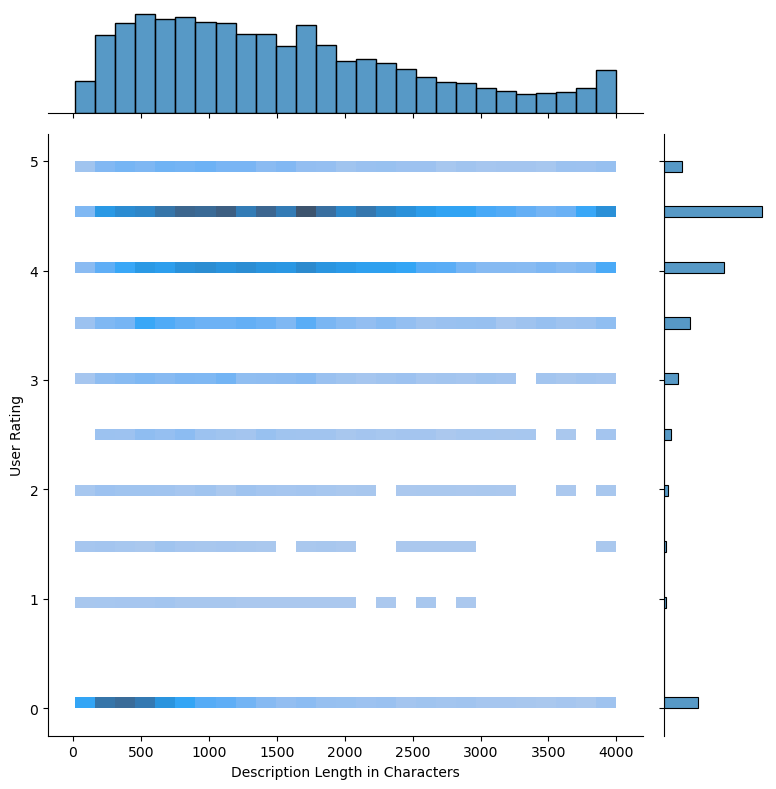

In [32]:
# Plot description length and user rating
sns.jointplot(kind="hist", height=8, x="description_characters", y="user_rating", data=df_desc_rating)
plt.xlabel('Description Length in Characters')
plt.ylabel('User Rating')
plt.show()

Lots of apps with a very short description (<500 characters) have a rating of 0. However, there are also many apps with good ratings (4 or higher) that have short descriptions. There are fewer apps with descriptions longer than 2000 characters, but those tend to have an overall higher rating. Especially bad or mediocre ratings (1 to 3) become fewer or even non-existent with increasing description length while maintaining lots of good ratings. It is therefore <b>advisable to include a rather long description</b>.

## Insights and Recommendations

### Genre
It is recommended to develop an app in one of the following genres:
- Catalogs
- Finance
- Book
- Navigation

These genres have the lowest average ratings which indicates that users are not happy with available apps in these genres.

### Price
Paid apps are higher rated on average. It is recommended to set the price below the average of around 4 dollars. These apps are rated highest amongst the paid apps. A free app (or a demo version) can be used to attract more customers because free apps are rated nearly five times as often as paid apps.

### Language Support
The app should support between 11 and 20 languages. Apps in these range tend to have the highest ratings.

### Description
While short descriptions don't necessarily mean lower ratings, it is recommended to include a rather long description for the app. There are fewer apps with long descriptions, making it easier to stand out there. Longer descriptions tend to result in a higher rating.